# 映画のレビューの感情分析

## 【ライブラリのインポート】

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%matplotlib inline
sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")

from sklearn.feature_extraction.text import CountVectorizer

CountVectorizerをインスタンス化

In [2]:
vect = CountVectorizer()

解析されたフレーズごとに分類精度（正しく予測されたラベルの割合）で評価される。<br>
0:否定的<br>
1:やや否定的<br>
2:中立<br>
3:やや肯定的<br>
4:肯定的

提出形式・・・テストセット内の各フレーズについて、感情のラベルを予測する。<br>
**PhraseID, Sentiment**という形式で提出する。

## 【データセットをpandasで読みこむ。】

In [3]:
train_df = pd.read_csv("train.tsv", delimiter='\t')
test_df = pd.read_csv("test.tsv", delimiter='\t')

In [4]:
train_df[train_df['Phrase'].isnull()]

,PhraseId,SentenceId,Phrase,Sentiment


In [5]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### 欠損値の確認
欠損値のあるデータを見てたところ、欠損値は存在しなかった。
（ちなみに、欠損値が存在する行を削除する手法を、「リストワイズ法」という。<br>
これは、訓練データにのみ使用することができる。<br>
訓練データの削除は「削除したデータは学習に使用しない」と捉えることができるが、<br>テストデータは予測しなければならないデータなので、削除を行なった場合は、欠損値をもつサンプルに対する予測を破棄することになり、望ましくない。

In [7]:
train_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
test_df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

## 【探索的データ分析】

・スコア「２」のレビューが多そう。（「中立」のレビュー）<br>
・同一なレビューは無い。（freq=1だから）

In [9]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [10]:
train_df.describe(exclude='number')

,Phrase
count,156060
unique,156060
top,A series of escapades demonstrating the adage ...
freq,1


文字数を算出してみる。

In [14]:
train_df['Phrase_len'] = train_df.Phrase.apply(len)
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len
0,1,1,A series of escapades demonstrating the adage ...,1,188
1,2,1,A series of escapades demonstrating the adage ...,2,77
2,3,1,A series,2,8
3,4,1,A,2,1
4,5,1,series,2,6


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Phrase Length')

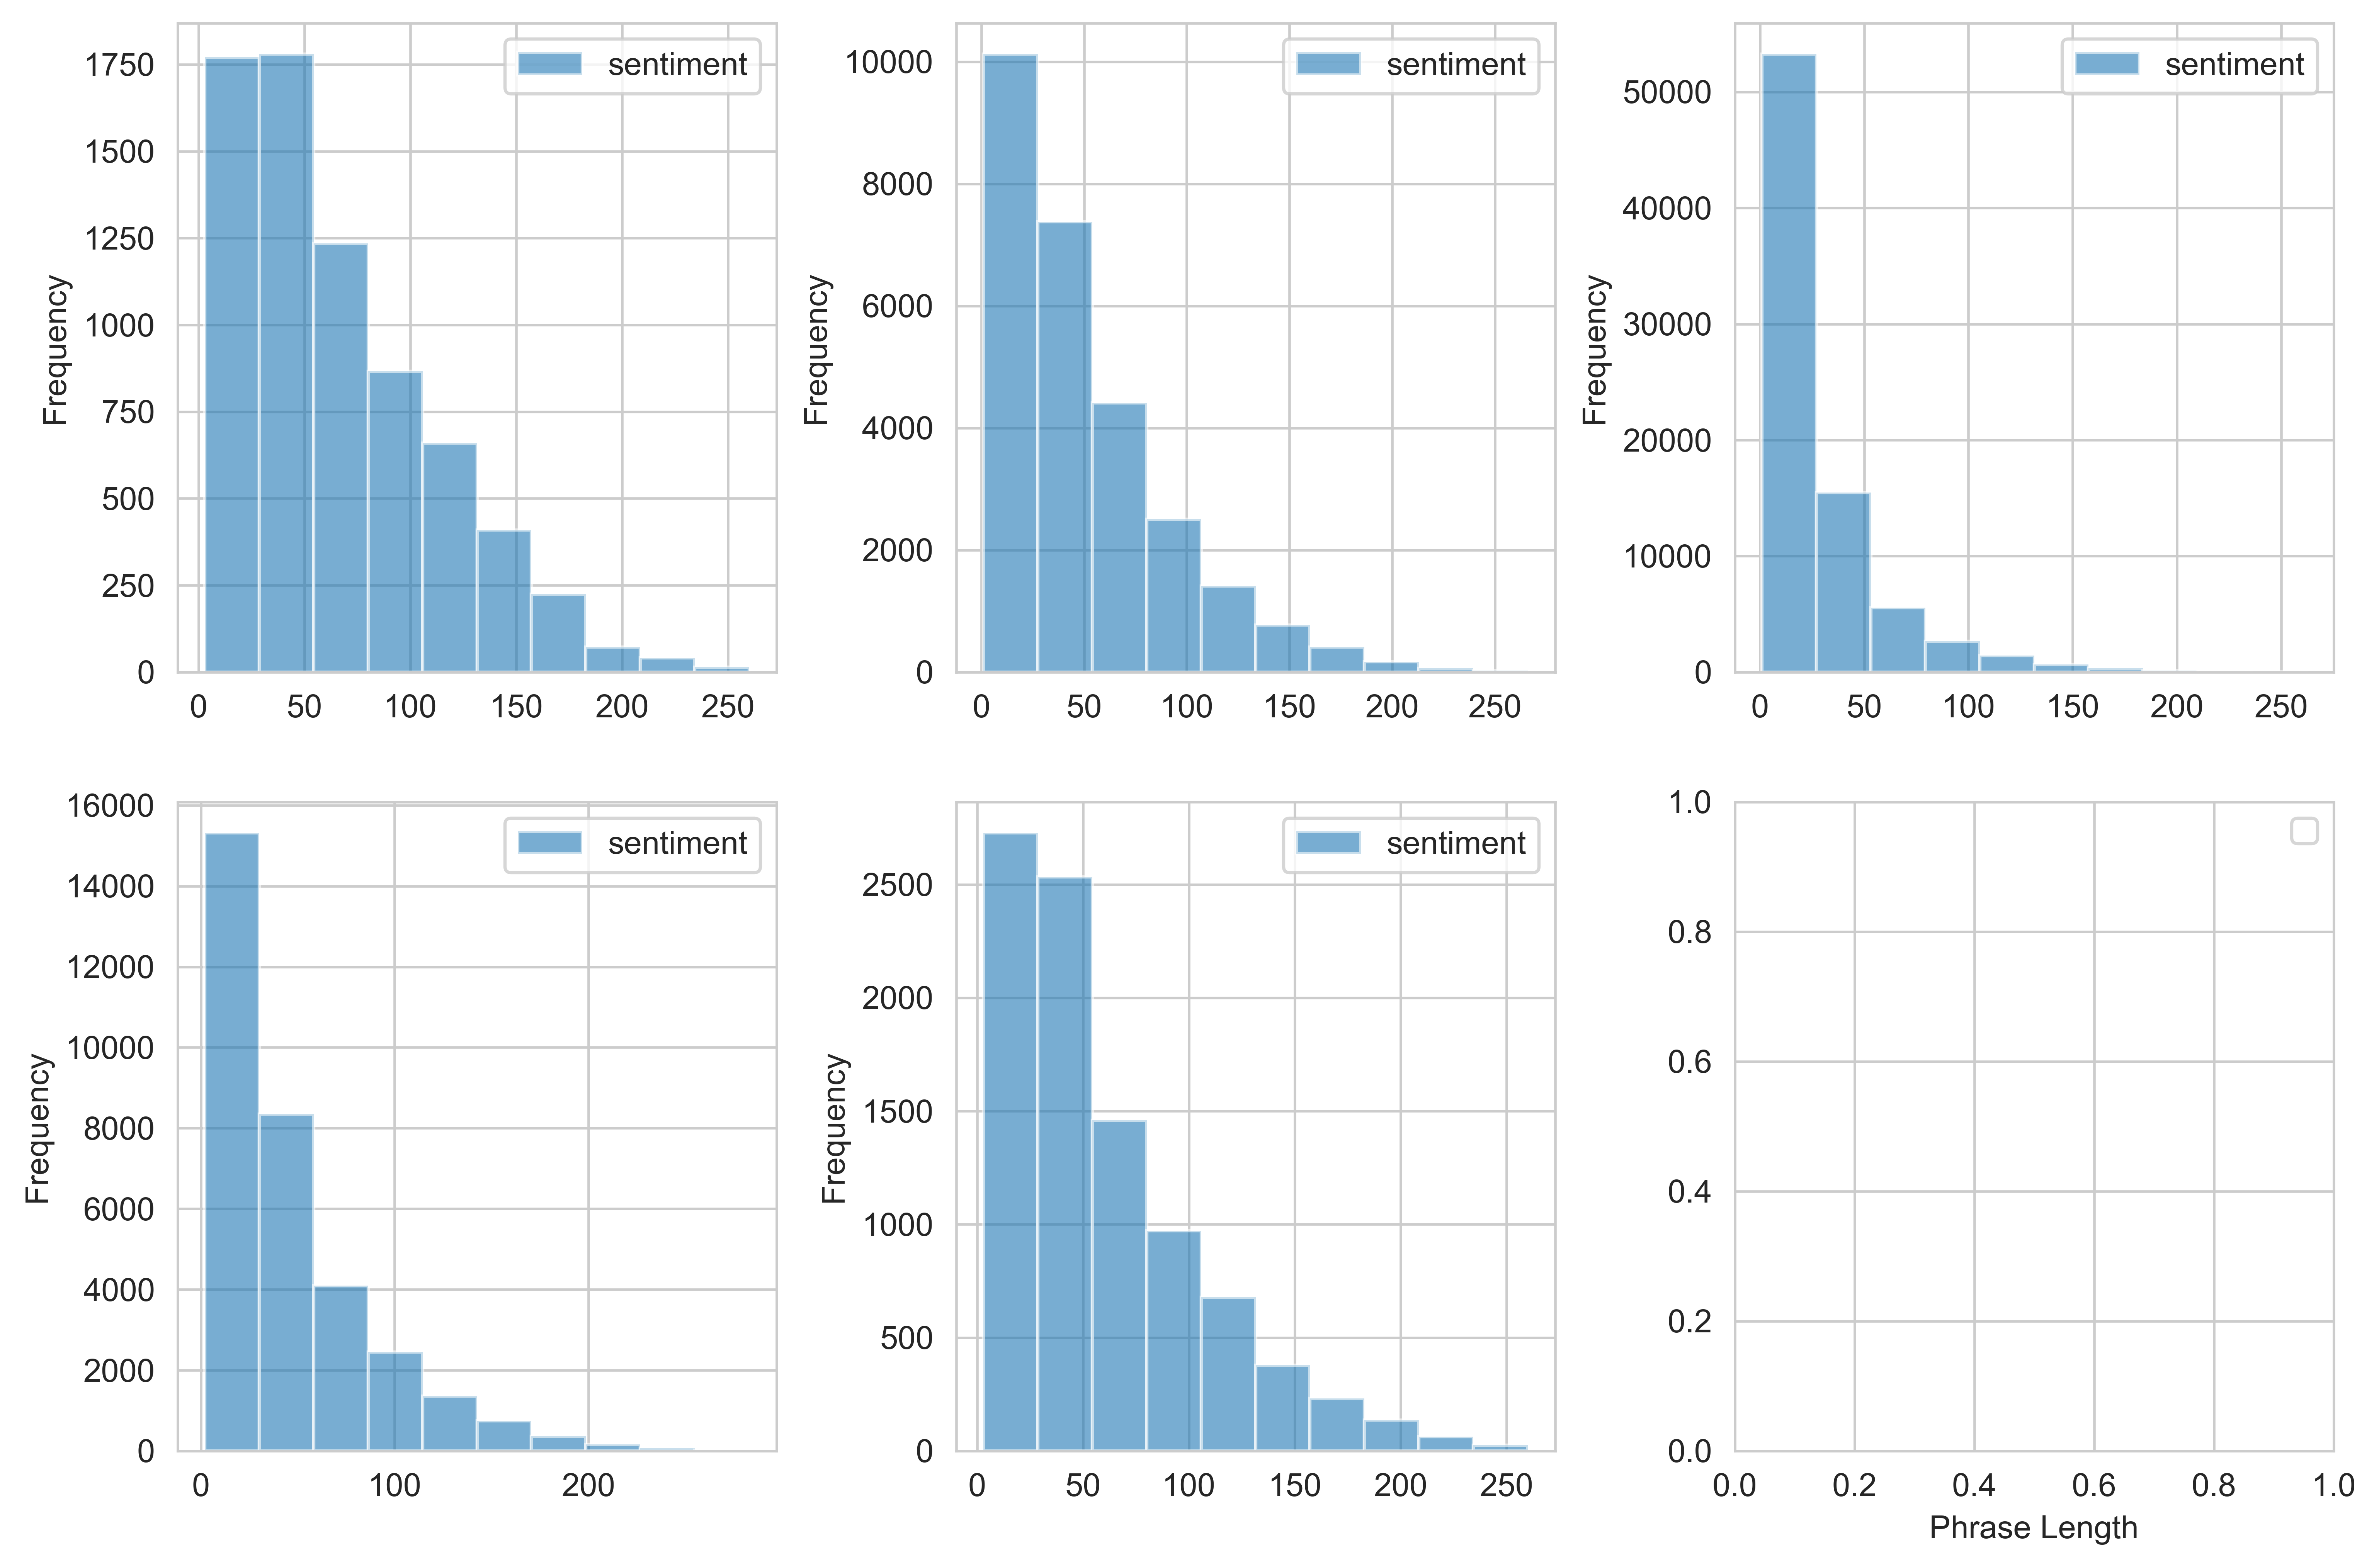

In [94]:
# plt.figure(figsize=(12, 8), dpi=600)
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.xlabel("Phrase Length")

train_df[train_df.Sentiment==0].Phrase_len.plot(ax=ax[0,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==1].Phrase_len.plot(ax=ax[0,1], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==2].Phrase_len.plot(ax=ax[0,2], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==3].Phrase_len.plot(ax=ax[1,0], kind='hist', label='sentiment', alpha=0.6, legend=True)
train_df[train_df.Sentiment==4].Phrase_len.plot(ax=ax[1,1], kind='hist', label='sentiment', alpha=0.6, legend=True)

plt.legend()
plt.xlabel("Phrase Length")

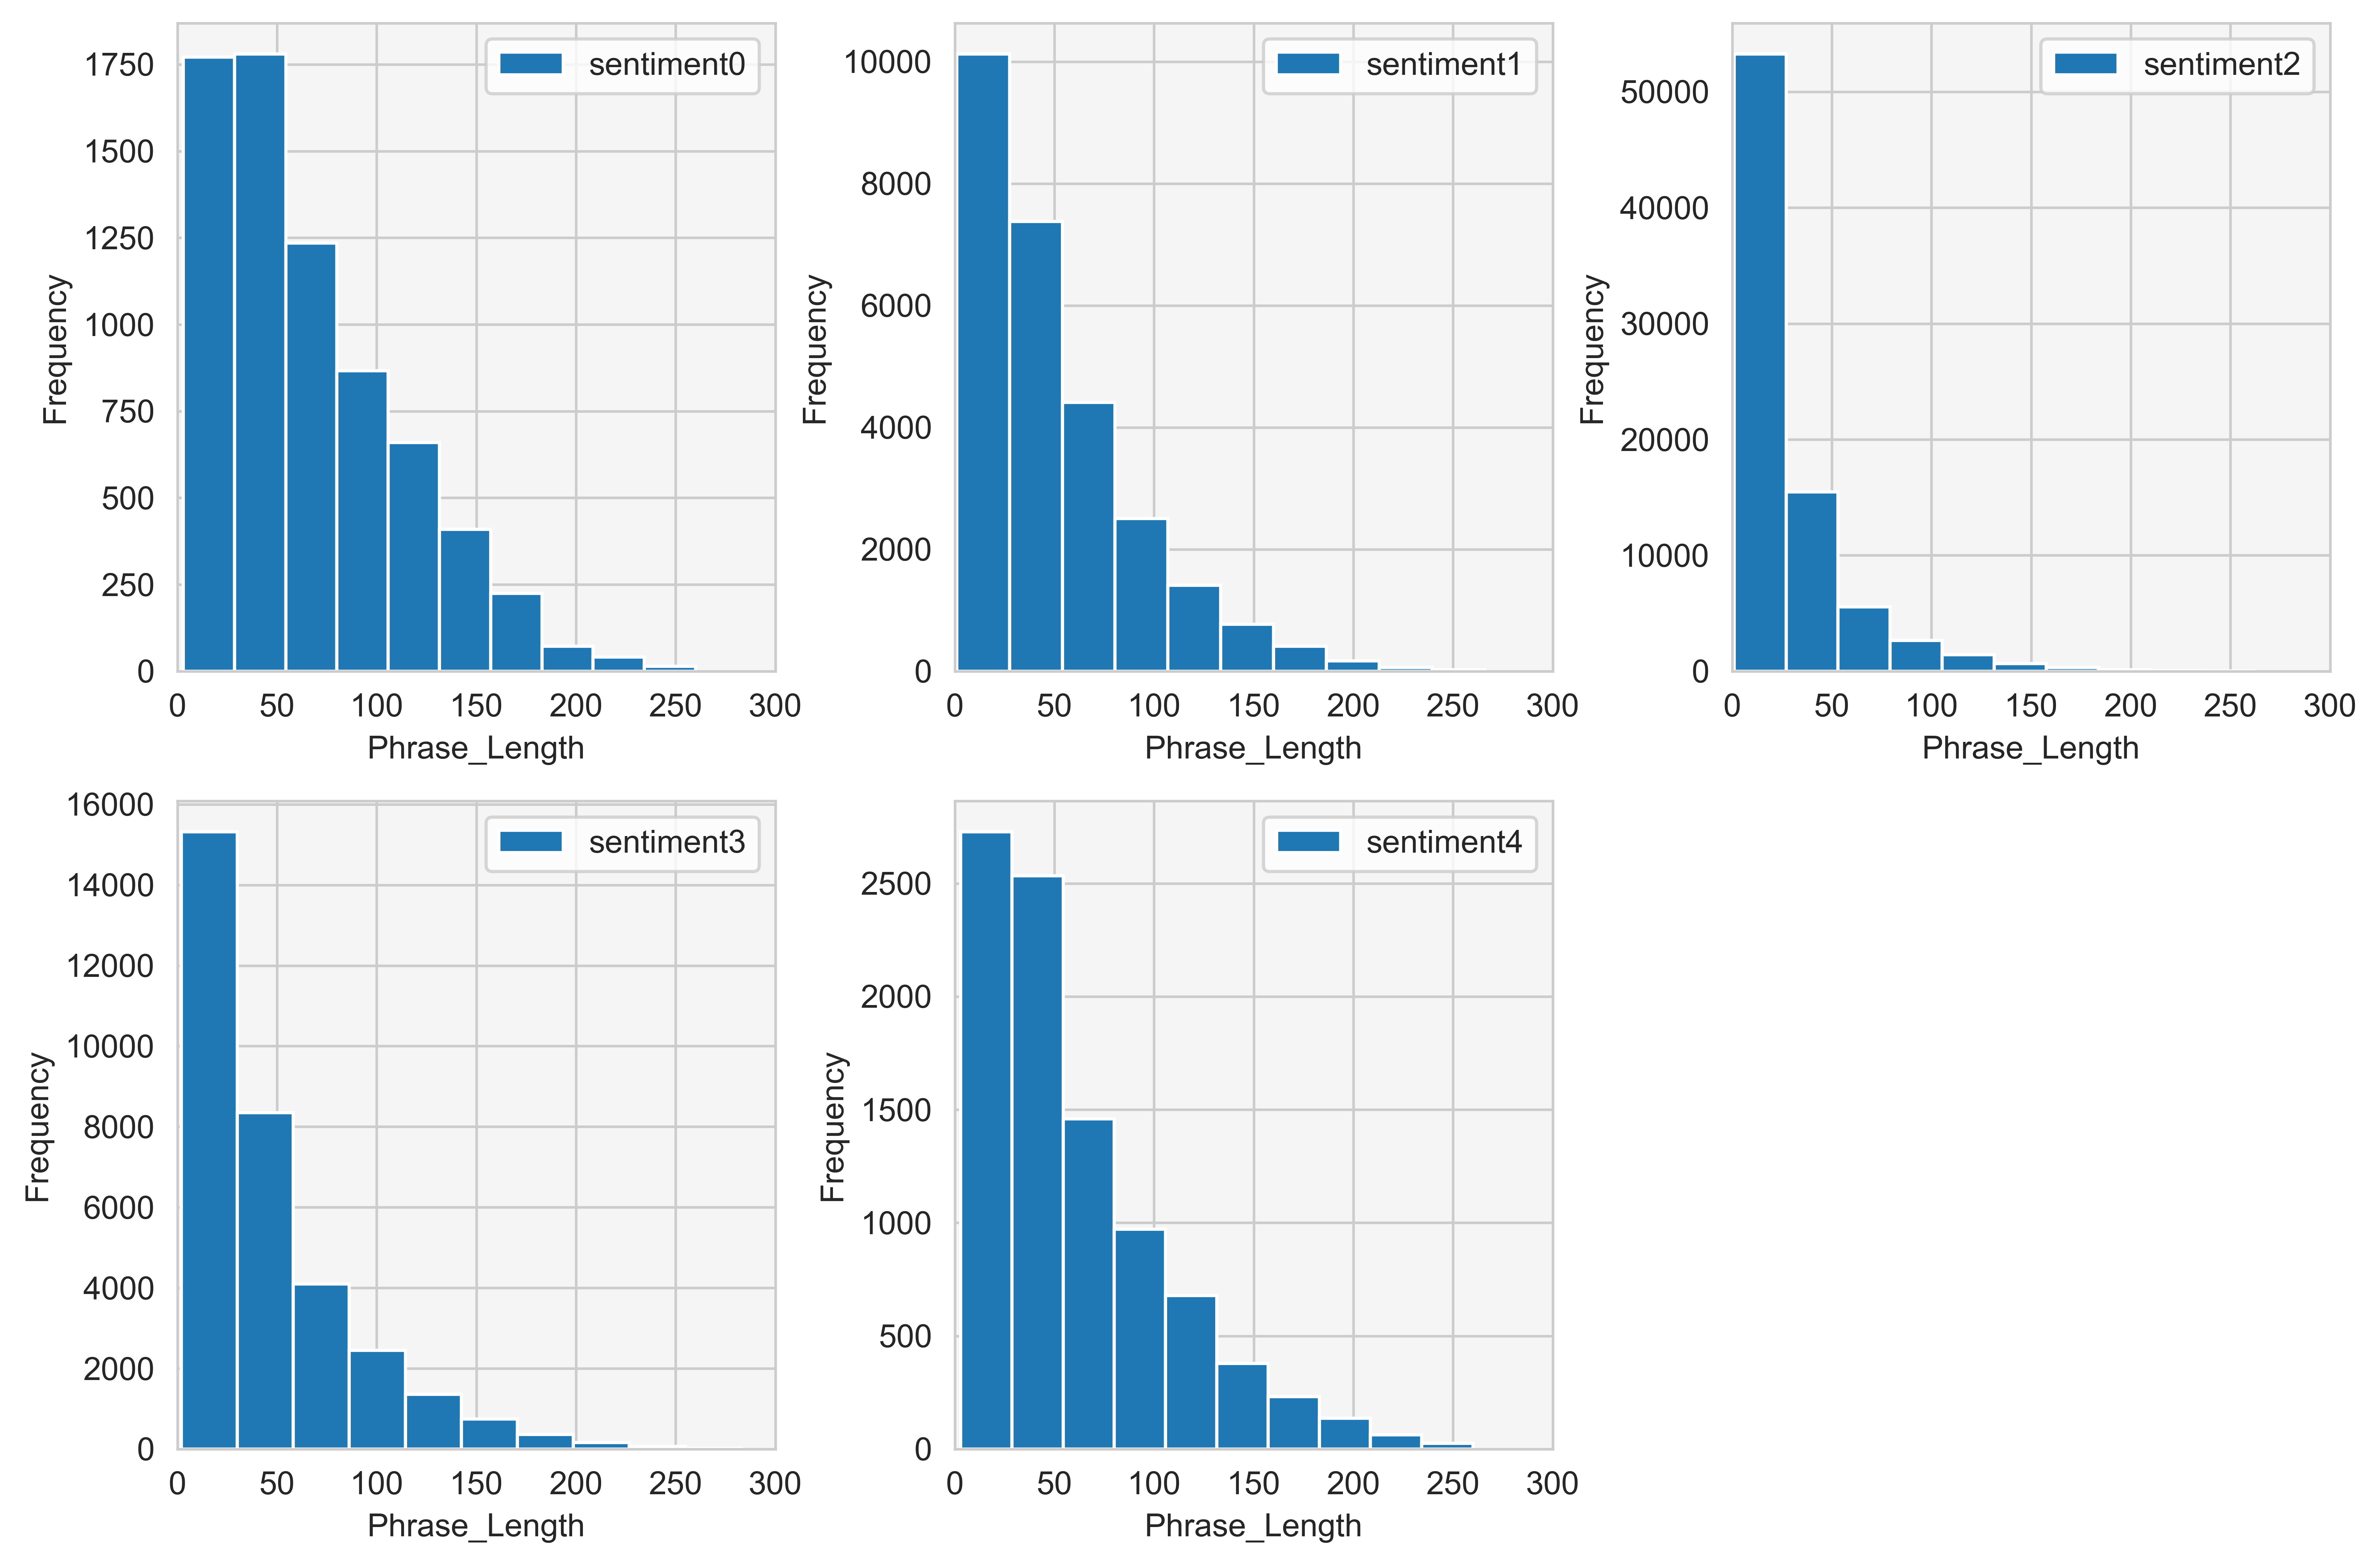

In [128]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), dpi=600)
plt.subplots_adjust(wspace=0.3, hspace=0.2)

background_color = "#f6f5f5"

run_no = 0
for row in range(0,2):
    for col in range(0, 3):
        locals()["ax"+str(run_no)] = train_df[train_df.Sentiment==run_no].Phrase_len.plot(ax=ax[row, col], kind='hist', label='sentiment'+str(run_no), legend=True, edgecolor="black". )
        locals()["ax"+str(run_no)].set_xlabel("Phrase_Length")
        locals()["ax"+str(run_no)].set_xlim(0, 300)
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        run_no += 1

ax5.remove()
plt.show()

Text(0.5, 0, 'Phrase Length')

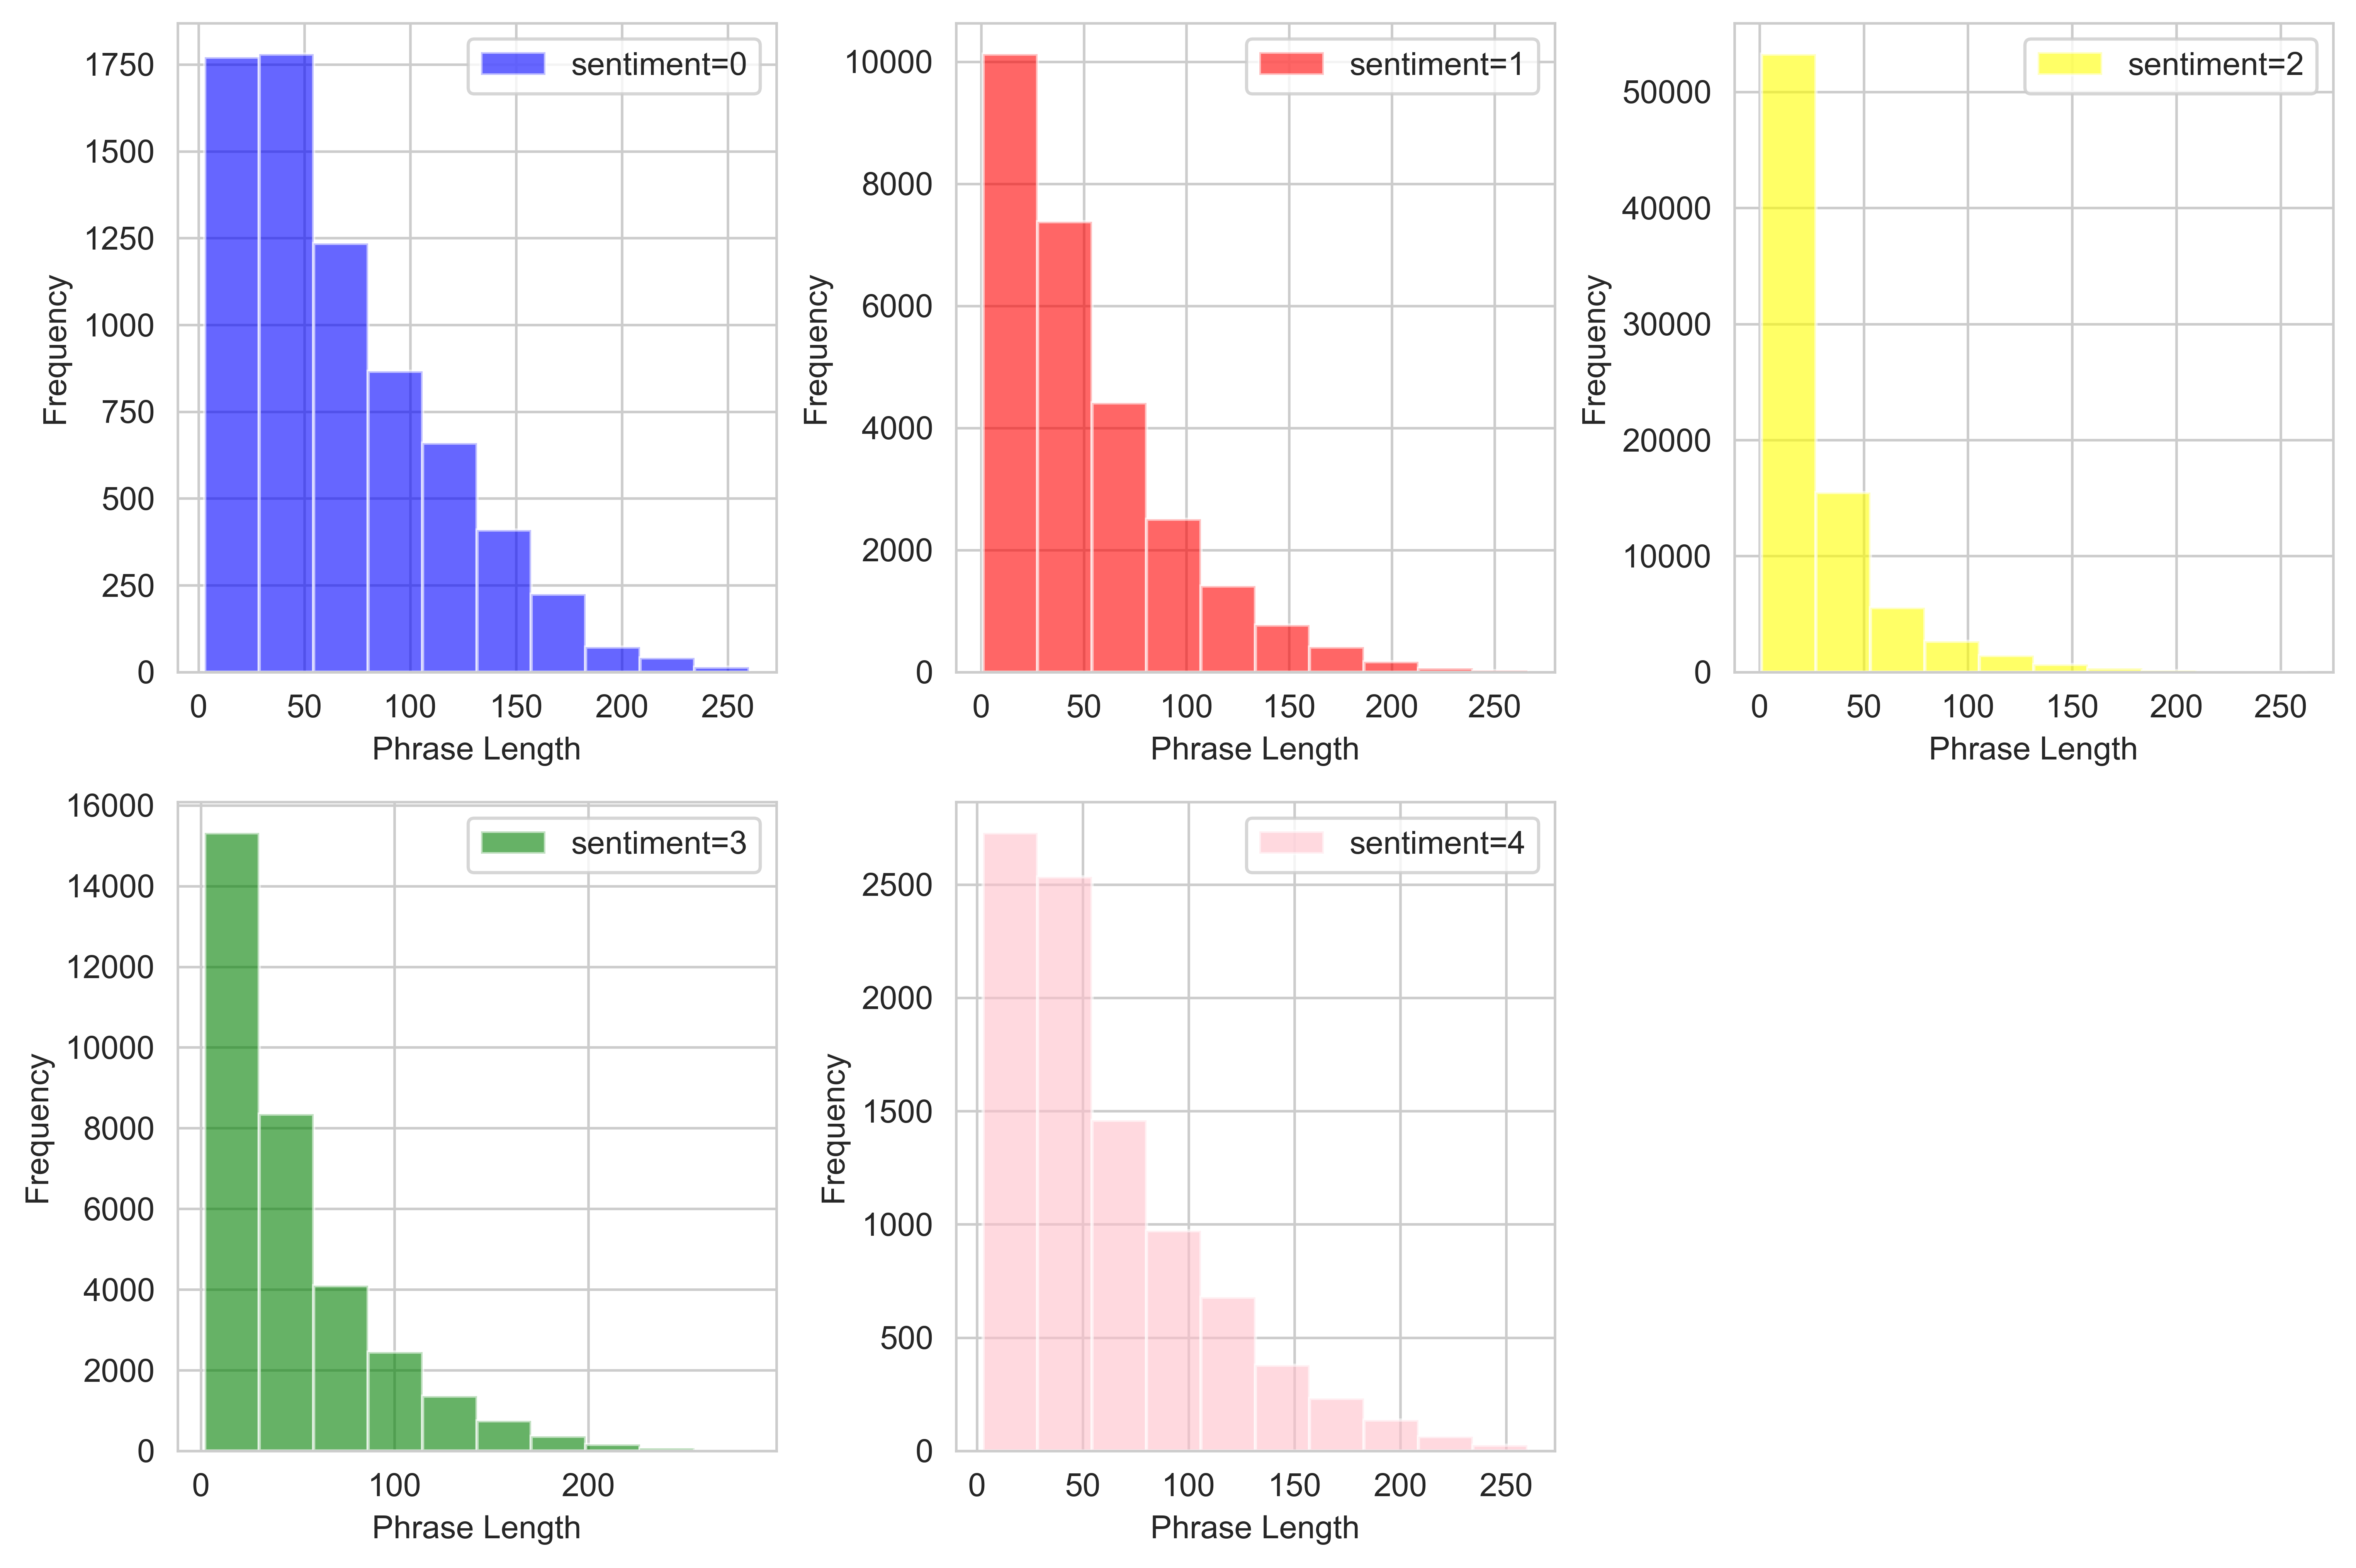

In [91]:
# fig = plt.figure(figsize=(12, 8), dpi=600)
# plt.subplots_adjust(wspace=0.3, hspace=0.2)

# ax0 = fig.add_subplot(231)
# train_df[train_df.Sentiment==0].Phrase_len.plot(kind='hist', color='blue', label='sentiment=0', alpha=0.6, legend=True)
# ax0.set_xlabel("Phrase Length")

# ax1 = fig.add_subplot(232)
# train_df[train_df.Sentiment==1].Phrase_len.plot(kind='hist', color='red', label='sentiment=1', alpha=0.6, legend=True)
# ax1.set_xlabel("Phrase Length")

# ax2 = fig.add_subplot(233)
# train_df[train_df.Sentiment==2].Phrase_len.plot(kind='hist', color='yellow', label='sentiment=2', alpha=0.6, legend=True)
# ax2.set_xlabel("Phrase Length")

# ax3 = fig.add_subplot(234)
# train_df[train_df.Sentiment==3].Phrase_len.plot(kind='hist', color='green', label='sentiment=3', alpha=0.6, legend=True)
# ax3.set_xlabel("Phrase Length")

# ax4 = fig.add_subplot(235)
# train_df[train_df.Sentiment==4].Phrase_len.plot(kind='hist', color='pink', label='sentiment=4', alpha=0.6, legend=True)
# ax4.set_xlabel("Phrase Length")